## Bloqs with specialized controlled implementations

In some cases, a bloq may have a specialized singly-controlled version (e.g. `LCUBlockEncoding`).
Qualtran provides a convenience methods `get_ctrl_system_1bit_cv` and `get_ctrl_system_1bit_cv_from_bloqs` to override the `get_ctrl_system`. These methods ensure that multiply-controlled bloqs are correctly reduced to the provided singly-controlled variants.

- `get_ctrl_system_1bit_cv_from_bloqs` - Override when a specialized controlled-by-1 implementation is available.
- `get_ctrl_system_1bit_cv` - Override when both specialized controlled-by-1 and controlled-by-0 implementations are available.

The following demonstrates an example for a bloq implementing $T^\dagger X T$, where the controlled version only needs to control the $X$.

In [1]:
import attrs
from qualtran import Bloq, BloqBuilder, Soquet, SoquetT, Signature, CtrlSpec, AddControlledT
from qualtran.bloqs.basic_gates import TGate, XGate, CNOT


@attrs.frozen
class BloqWithSpecializedCtrl(Bloq):
    """Bloq implementing $T^\dagger X T$"""
    is_controlled: bool = False

    @property
    def signature(self) -> 'Signature':
        n_ctrls = 1 if self.is_controlled else 0
        return Signature.build(ctrl=n_ctrls, q=1)
    
    def build_composite_bloq(self, bb: 'BloqBuilder', q: 'Soquet', **soqs) -> dict[str, 'SoquetT']:
        ctrl = soqs.pop('ctrl', None)
        
        q = bb.add(TGate(), q=q)
        if self.is_controlled:
            ctrl, q = bb.add(CNOT(), ctrl=ctrl, target=q)
        else:
            ctrl, q = bb.add(XGate(), ctrl=ctrl, target=q)
        q = bb.add(TGate().adjoint(), q=q)
        
        out_soqs = {'q': q}
        if ctrl:
            out_soqs |= {'ctrl': ctrl}
        return out_soqs
    
    def get_ctrl_system(self, ctrl_spec: 'CtrlSpec') -> tuple['Bloq', 'AddControlledT']:
        from qualtran.bloqs.mcmt.specialized_ctrl import get_ctrl_system_1bit_cv_from_bloqs

        return get_ctrl_system_1bit_cv_from_bloqs(
            self,
            ctrl_spec,
            current_ctrl_bit=1 if self.is_controlled else None,
            bloq_with_ctrl=attrs.evolve(self, is_controlled=True),
            ctrl_reg_name='ctrl',
        )

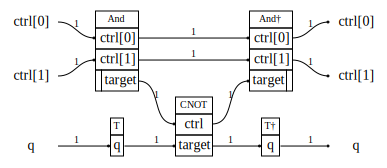

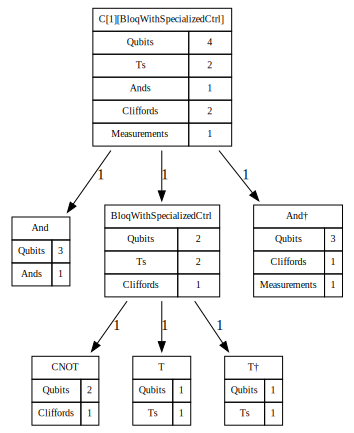

In [2]:
from qualtran.drawing import show_bloq, show_call_graph

bloq = BloqWithSpecializedCtrl().controlled().controlled()
show_bloq(bloq.decompose_bloq().flatten())
show_call_graph(bloq)

## Propagating the Adjoint

In the above bloq, calling controlled on the adjoint does not push the controls into the bloq, and therefore does not use the specialized implementation provided.

In [3]:
BloqWithSpecializedCtrl().adjoint().controlled()

Controlled(subbloq=Adjoint(subbloq=BloqWithSpecializedCtrl(is_controlled=False)), ctrl_spec=CtrlSpec(qdtypes=(QBit(),), cvs=(array(1),)))

This can be fixed by overriding the adjoint using a special wrapper for this case - `AdjointWithSpecializedCtrl`. This is a subclass of the default `Adjoint` metabloq, and ensures that single-qubit controls are pushed into the underlying bloq.

In [4]:
@attrs.frozen
class BloqWithSpecializedCtrlWithAdjoint(Bloq):
    """Bloq implementing $T^\dagger X T$"""
    is_controlled: bool = False

    @property
    def signature(self) -> 'Signature':
        n_ctrls = 1 if self.is_controlled else 0
        return Signature.build(ctrl=n_ctrls, q=1)
    
    def build_composite_bloq(self, bb: 'BloqBuilder', q: 'Soquet', **soqs) -> dict[str, 'SoquetT']:
        ctrl = soqs.pop('ctrl', None)
        
        q = bb.add(TGate(), q=q)
        if self.is_controlled:
            ctrl, q = bb.add(CNOT(), ctrl=ctrl, target=q)
        else:
            ctrl, q = bb.add(XGate(), ctrl=ctrl, target=q)
        q = bb.add(TGate().adjoint(), q=q)
        
        out_soqs = {'q': q}
        if ctrl:
            out_soqs |= {'ctrl': ctrl}
        return out_soqs
    
    def get_ctrl_system(self, ctrl_spec: 'CtrlSpec') -> tuple['Bloq', 'AddControlledT']:
        from qualtran.bloqs.mcmt.specialized_ctrl import get_ctrl_system_1bit_cv_from_bloqs

        return get_ctrl_system_1bit_cv_from_bloqs(
            self,
            ctrl_spec,
            current_ctrl_bit=1 if self.is_controlled else None,
            bloq_with_ctrl=attrs.evolve(self, is_controlled=True),
            ctrl_reg_name='ctrl',
        )

    def adjoint(self):
        from qualtran.bloqs.mcmt.specialized_ctrl import AdjointWithSpecializedCtrl, SpecializeOnCtrlBit
        
        return AdjointWithSpecializedCtrl(self, SpecializeOnCtrlBit.ONE)

In [5]:
BloqWithSpecializedCtrlWithAdjoint().adjoint().controlled()

AdjointWithSpecializedCtrl(subbloq=BloqWithSpecializedCtrlWithAdjoint(is_controlled=True), specialize_on_ctrl=<SpecializeOnCtrlBit.ONE: 4>)

In [6]:
assert BloqWithSpecializedCtrlWithAdjoint().adjoint().controlled() == BloqWithSpecializedCtrlWithAdjoint(is_controlled=True).adjoint()